The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# 预训练BERT
:label:`sec_bert-pretraining`

利用 :numref:`sec_bert`中实现的BERT模型和 :numref:`sec_bert-dataset`中从WikiText-2数据集生成的预训练样本，我们将在本节中在WikiText-2数据集上对BERT进行预训练。


In [1]:
import warnings
from d2l import paddle as d2l

warnings.filterwarnings("ignore")
import paddle
from paddle import nn

首先，我们加载WikiText-2数据集作为小批量的预训练样本，用于遮蔽语言模型和下一句预测。批量大小是512，BERT输入序列的最大长度是64。注意，在原始BERT模型中，最大长度是512。


In [2]:
def load_data_wiki(batch_size, max_len):
    """加载WikiText-2数据集

    Defined in :numref:`subsec_prepare_mlm_data`"""
    data_dir = d2l.download_extract('wikitext-2', 'wikitext-2')
    paragraphs = d2l._read_wiki(data_dir)
    train_set = d2l._WikiTextDataset(paragraphs, max_len)
    train_iter = paddle.io.DataLoader(dataset=train_set, batch_size=batch_size, return_list=True,
                                        shuffle=True, num_workers=0)
    return train_iter, train_set.vocab

batch_size, max_len = 512, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)

正在从https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip下载../data/wikitext-2-v1.zip...


## 预训练BERT

原始BERT :cite:`Devlin.Chang.Lee.ea.2018`有两个不同模型尺寸的版本。基本模型（$\text{BERT}_{\text{BASE}}$）使用12层（Transformer编码器块），768个隐藏单元（隐藏大小）和12个自注意头。大模型（$\text{BERT}_{\text{LARGE}}$）使用24层，1024个隐藏单元和16个自注意头。值得注意的是，前者有1.1亿个参数，后者有3.4亿个参数。为了便于演示，我们定义了一个小的BERT，使用了2层、128个隐藏单元和2个自注意头。


In [3]:
net = d2l.BERTModel(len(vocab), num_hiddens=128, norm_shape=[128],
                    ffn_num_input=128, ffn_num_hiddens=256, num_heads=2,
                    num_layers=2, dropout=0.2, key_size=128, query_size=128,
                    value_size=128, hid_in_features=128, mlm_in_features=128,
                    nsp_in_features=128)
devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss()

W0814 20:58:38.286195  3411 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.8, Runtime API Version: 11.8
W0814 20:58:38.322496  3411 gpu_resources.cc:91] device: 0, cuDNN Version: 8.7.


在定义训练代码实现之前，我们定义了一个辅助函数`_get_batch_loss_bert`。给定训练样本，该函数计算遮蔽语言模型和下一句子预测任务的损失。请注意，BERT预训练的最终损失是遮蔽语言模型损失和下一句预测损失的和。


In [4]:
#@save
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    # 前向传播
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape([-1]),
                                  pred_positions_X)
    # 计算遮蔽语言模型损失
    mlm_l = loss(mlm_Y_hat.reshape([-1, vocab_size]), mlm_Y.reshape([-1])) *\
    mlm_weights_X.reshape([-1, 1])
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # 计算下一句子预测任务的损失
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

通过调用上述两个辅助函数，下面的`train_bert`函数定义了在WikiText-2（`train_iter`）数据集上预训练BERT（`net`）的过程。训练BERT可能需要很长时间。以下函数的输入`num_steps`指定了训练的迭代步数，而不是像`train_ch13`函数那样指定训练的轮数（参见 :numref:`sec_image_augmentation`）。


In [5]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    trainer = paddle.optimizer.Adam(parameters=net.parameters(), learning_rate=0.01)
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # 遮蔽语言模型损失的和，下一句预测任务损失的和，句子对的数量，计数
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X,\
            mlm_weights_X, mlm_Y, nsp_y in train_iter:
            trainer.clear_grad()
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')

在预训练过程中，我们可以绘制出遮蔽语言模型损失和下一句预测损失。


MLM loss 5.873, NSP loss 0.846
9029.3 sentence pairs/sec on [Place(gpu:0)]


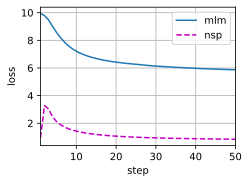

In [6]:
train_bert(train_iter, net, loss, len(vocab), devices[:1], 50)

## 用BERT表示文本

在预训练BERT之后，我们可以用它来表示单个文本、文本对或其中的任何词元。下面的函数返回`tokens_a`和`tokens_b`中所有词元的BERT（`net`）表示。


In [7]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = paddle.to_tensor(vocab[tokens]).unsqueeze(0)
    segments = paddle.to_tensor(segments).unsqueeze(0)
    valid_len = paddle.to_tensor(len(tokens))

    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

考虑“a crane is flying”这句话。回想一下 :numref:`subsec_bert_input_rep`中讨论的BERT的输入表示。插入特殊标记“&lt;cls&gt;”（用于分类）和“&lt;sep&gt;”（用于分隔）后，BERT输入序列的长度为6。因为零是“&lt;cls&gt;”词元，`encoded_text[:, 0, :]`是整个输入语句的BERT表示。为了评估一词多义词元“crane”，我们还打印出了该词元的BERT表示的前三个元素。


In [8]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
# 词元：'<cls>','a','crane','is','flying','<sep>'
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

([1, 6, 128],
 [1, 128],
 Tensor(shape=[3], dtype=float32, place=Place(gpu:0), stop_gradient=False,
        [-0.55687404,  0.74945056,  0.23141932]))

现在考虑一个句子“a crane driver came”和“he just left”。类似地，`encoded_pair[:, 0, :]`是来自预训练BERT的整个句子对的编码结果。注意，多义词元“crane”的前三个元素与上下文不同时的元素不同。这支持了BERT表示是上下文敏感的。


In [9]:
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# 词元：'<cls>','a','crane','driver','came','<sep>','he','just',
# 'left','<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

([1, 10, 128],
 [1, 128],
 Tensor(shape=[3], dtype=float32, place=Place(gpu:0), stop_gradient=False,
        [0.04915407, 0.76677966, 0.27145046]))

在 :numref:`chap_nlp_app`中，我们将为下游自然语言处理应用微调预训练的BERT模型。

## 小结

* 原始的BERT有两个版本，其中基本模型有1.1亿个参数，大模型有3.4亿个参数。
* 在预训练BERT之后，我们可以用它来表示单个文本、文本对或其中的任何词元。
* 在实验中，同一个词元在不同的上下文中具有不同的BERT表示。这支持BERT表示是上下文敏感的。

## 练习

1. 在实验中，我们可以看到遮蔽语言模型损失明显高于下一句预测损失。为什么？
2. 将BERT输入序列的最大长度设置为512（与原始BERT模型相同）。使用原始BERT模型的配置，如$\text{BERT}_{\text{LARGE}}$。运行此部分时是否遇到错误？为什么？


[Discussions](https://discuss.d2l.ai/t/11824)
